# LSTM model for stock prediction


Add the file description and seyup here

In [21]:
# Step 0: Import Libraries

import os
import math
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
plt.style.use("seaborn-v0_8")


In [22]:
# enable GPU is running the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [24]:
# Helper: create rolling sequences for LSTM
def create_sequences(series, n_past):
    """
    series: 1D numpy array of shape (T,)
    n_past: number of past time steps to use as input

    Returns:
        X: (num_samples, n_past, 1)
        y: (num_samples,)
    """
    X, y = [], []
    for i in range(n_past, len(series)):
        X.append(series[i - n_past:i])
        y.append(series[i])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)  # add feature dimension
    return X, y


In [27]:
# Paths relative to project root
DATA_ROOT = "../../data/archive"
Symbols_path = os.path.join(DATA_ROOT, "symbols_valid_meta.csv")

tickers_df = pd.read_csv(Symbols_path)

print("Meta columns:", tickers_df.columns.tolist())
print("Number of symbols in meta:", len(tickers_df))

# Example: A
# May change how to pick the symbol to be done on function call 

target_ticker = "A"

# Find symbol row
row = tickers_df[tickers_df["Symbol"] == target_ticker]
if row.empty:
    raise ValueError(f"Symbol {target_ticker} not found in metadata.")

is_etf = (row["ETF"].iloc[0] == "Y")
asset_type = "etfs" if is_etf else "stocks"

print(f"Selected symbol: {target_ticker} | ETF? {is_etf} | Folder: {asset_type}")


Meta columns: ['Nasdaq Traded', 'Symbol', 'Security Name', 'Listing Exchange', 'Market Category', 'ETF', 'Round Lot Size', 'Test Issue', 'Financial Status', 'CQS Symbol', 'NASDAQ Symbol', 'NextShares']
Number of symbols in meta: 8049
Selected symbol: A | ETF? False | Folder: stocks


In [31]:
#Load data of selected ticker
data_path = os.path.join(DATA_ROOT, asset_type, f"{target_ticker}.csv")
stock_df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,27.068665,62546300
1,1999-11-19,30.713520,30.758226,28.478184,28.880543,24.838577,15234100
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.068665,6577800
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.607880,5975600
4,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.261524,4843200


In [35]:
# Make sure there is a date column named "Date"
if "Date" not in stock_df.columns:
    if "date" in stock_df.columns:
        stock_df = stock_df.rename(columns={"date": "Date"})
    else:
        raise KeyError("Could not find a 'Date' or 'date' column in the CSV.")

# Ensure we have a closing price column named "Close"
if "Close" not in stock_df.columns:
    # Some datasets use "Adj Close" or "close"
    if "Adj Close" in stock_df.columns:
        stock_df = stock_df.rename(columns={"Adj Close": "Close"})
    elif "close" in stock_df.columns:
        stock_df = stock_df.rename(columns={"close": "Close"})
    else:
        raise KeyError("Could not find a 'Close', 'Adj Close', or 'close' column.")

# Convert Date to datetime and sort chronologically
stock_df["Date"] = pd.to_datetime(stock_df["Date"])
stock_df = stock_df.sort_values("Date").reset_index(drop=True)

print("Date range:", stock_df["Date"].min().date(), "to", stock_df["Date"].max().date())

# Optional: restrict the time window (you can adjust these)
start_date = datetime(2014, 1, 1)
end_date   = datetime(2020, 4, 1)  # e.g., up to April 2020 if using Kaggle archive

mask = (stock_df["Date"] >= start_date) & (stock_df["Date"] <= end_date)
stock_df = stock_df.loc[mask].reset_index(drop=True)


stock_df[["Date", "Close"]].head()


Date range: 2014-01-02 to 2020-04-01


,Date,Close
0,2014-01-02,40.207439
1,2014-01-03,40.715309
2,2014-01-06,40.515022
3,2014-01-07,41.094421
4,2014-01-08,41.766811


In [36]:
# Handle missing Close values (if any) by interpolation
stock_df["Close"] = stock_df["Close"].interpolate(method="linear", limit_direction="both")

dates = stock_df["Date"].values
close_prices = stock_df["Close"].values.reshape(-1, 1)
print("Original price shape:", close_prices.shape)

# Scale prices to [0, 1]
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(close_prices)

# Chronological split: 80% train / 20% test
train_size = int(len(scaled_prices) * 0.8)
train_data = scaled_prices[:train_size]
test_data  = scaled_prices[train_size:]

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Number of past days to use for prediction
n_past = 60

X_train, y_train = create_sequences(train_data.flatten(), n_past)
X_test,  y_test  = create_sequences(test_data.flatten(), n_past)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Original price shape: (1573, 1)
Train data shape: (1258, 1)
Test data shape: (315, 1)
X_train: (1198, 60, 1) y_train: (1198,)
X_test: (255, 60, 1) y_test: (255,)


In [37]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

X_test_tensor  = torch.from_numpy(X_test).float()
y_test_tensor  = torch.from_numpy(y_test).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, drop_last=False)


In [ ]:
# Create the LSTM Model
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, dropout=0.2):
        super(LSTMRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))      # out: (batch, seq_len, hidden_size)
        last_hidden = out[:, -1, :]          # last time step
        out = self.fc(last_hidden)           # (batch, 1)
        return out.squeeze(-1)               # (batch,)


In [ ]:
# Training and Evaluation Functions

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(dataloader.dataset)


def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(X_batch)
            loss = criterion(preds, y_batch)

            running_loss += loss.item() * X_batch.size(0)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    return running_loss / len(dataloader.dataset), all_targets, all_preds


In [67]:
# Train the Model and Evaluate Performance

model = LSTMRegressor(
    input_size=1,
    hidden_size=50,
    num_layers=2,
    dropout=0.2
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 100 # tune as needed


In [68]:
train_losses = []
test_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, _, _ = evaluate_model(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    if epoch == 1 or epoch % 5 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}")


Epoch 001 | Train Loss: 0.056536 | Test Loss: 0.102254
Epoch 005 | Train Loss: 0.001166 | Test Loss: 0.007559
Epoch 010 | Train Loss: 0.000927 | Test Loss: 0.007101
Epoch 015 | Train Loss: 0.000813 | Test Loss: 0.006768
Epoch 020 | Train Loss: 0.000759 | Test Loss: 0.007986
Epoch 025 | Train Loss: 0.000740 | Test Loss: 0.011184
Epoch 030 | Train Loss: 0.000659 | Test Loss: 0.009136
Epoch 035 | Train Loss: 0.000634 | Test Loss: 0.007882
Epoch 040 | Train Loss: 0.000660 | Test Loss: 0.007552
Epoch 045 | Train Loss: 0.000520 | Test Loss: 0.008087
Epoch 050 | Train Loss: 0.000538 | Test Loss: 0.008545
Epoch 055 | Train Loss: 0.000440 | Test Loss: 0.005959
Epoch 060 | Train Loss: 0.000475 | Test Loss: 0.004954
Epoch 065 | Train Loss: 0.000426 | Test Loss: 0.006616
Epoch 070 | Train Loss: 0.000362 | Test Loss: 0.005230
Epoch 075 | Train Loss: 0.000356 | Test Loss: 0.006424
Epoch 080 | Train Loss: 0.000344 | Test Loss: 0.004108
Epoch 085 | Train Loss: 0.000368 | Test Loss: 0.005990
Epoch 090 

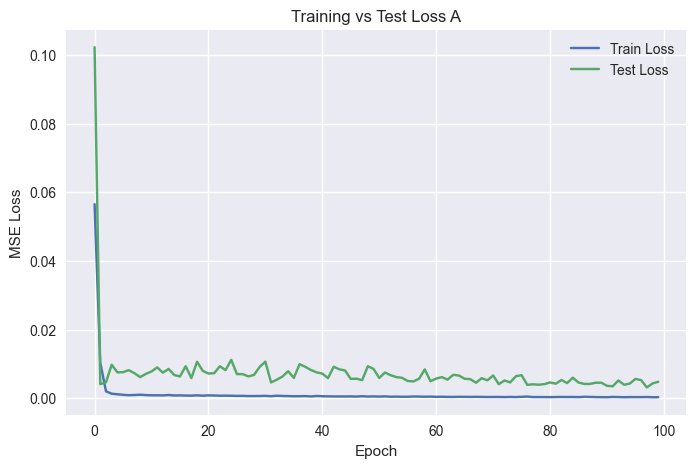

In [69]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"Training vs Test Loss {target_ticker}")
plt.legend()
plt.show()


In [70]:
train_loss, y_train_true_scaled, y_train_pred_scaled = evaluate_model(
    model, train_loader, criterion, device
)
test_loss, y_test_true_scaled, y_test_pred_scaled = evaluate_model(
    model, test_loader, criterion, device
)

# Inverse transform
y_train_true = scaler.inverse_transform(y_train_true_scaled.reshape(-1, 1)).flatten()
y_train_pred = scaler.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_true  = scaler.inverse_transform(y_test_true_scaled.reshape(-1, 1)).flatten()
y_test_pred  = scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

train_rmse = math.sqrt(mean_squared_error(y_train_true, y_train_pred))
test_rmse  = math.sqrt(mean_squared_error(y_test_true,  y_test_pred))

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test  RMSE: {test_rmse:.4f}")


Train RMSE: 0.8967
Test  RMSE: 3.9338


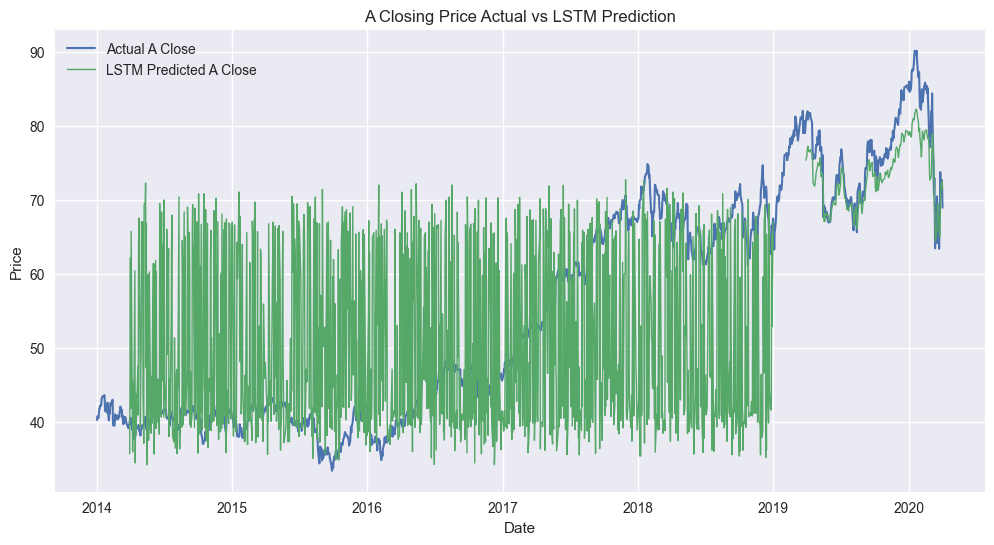

In [73]:
# Build full-length prediction array aligned with original dates

train_full_len = train_size
test_full_len  = len(scaled_prices) - train_size

# Train predictions occupy indices [n_past, train_full_len-1] in the train segment
train_pred_plot = np.empty(train_full_len)
train_pred_plot[:] = np.nan
train_pred_plot[n_past:] = y_train_pred

# Test predictions occupy indices [n_past, test_full_len-1] in the test segment
test_pred_plot = np.empty(test_full_len)
test_pred_plot[:] = np.nan
test_pred_plot[n_past:] = y_test_pred

actual_prices = close_prices.flatten()

full_pred = np.empty_like(actual_prices)
full_pred[:] = np.nan
full_pred[:train_full_len] = train_pred_plot
full_pred[train_full_len:] = test_pred_plot

plt.figure(figsize=(12, 6))
plt.plot(dates, actual_prices, label=f"Actual {target_ticker} Close", linewidth=1.5)
plt.plot(dates, full_pred, label=f"LSTM Predicted {target_ticker} Close", linewidth=1)
plt.title(f"{target_ticker} Closing Price Actual vs LSTM Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()



In [75]:
def query_price_and_trend(date_str,dates,actual_prices,full_pred,stock_df,model,scaler,scaled_prices,n_past,device):
    """
    Unified query function:

    - If date_str is within the historical dataset:
        -> report actual close, predicted close (if available), and predicted trend.
    - If date_str is after the last known date:
        -> forecast forward from the last known date to target date (business days),
           report forecasted price and trend (based on predictions only).
    """
    target_date = pd.to_datetime(date_str).normalize()
    first_date = stock_df["Date"].min().normalize()
    last_date  = stock_df["Date"].max().normalize()

    # -------- Case 1: date is before our dataset --------
    if target_date < first_date:
        print(f"Date {date_str} is before the first available date "
              f"({first_date.date()}) for {target_ticker}.")
        return

    # -------- Case 2: date is inside the dataset --------
    if target_date <= last_date:
        target_np = np.datetime64(target_date)
        indices = np.where(dates == target_np)[0]

        if len(indices) == 0:
            print(f"Date {date_str} not found in the dataset for {target_ticker}.")
            return

        i = indices[0]
        actual = actual_prices[i]
        pred = full_pred[i]

        print(f"=== {target_ticker} on {date_str} (within dataset) ===")
        print(f"Actual close: {actual:.4f}")

        if np.isnan(pred):
            print("No LSTM prediction available for this date (likely in the initial window).")
            return

        print(f"Predicted close: {pred:.4f}")

        if i == 0 or np.isnan(full_pred[i - 1]):
            print("Cannot compute predicted trend: missing previous prediction.")
            return

        prev_pred = full_pred[i - 1]
        if pred > prev_pred:
            trend = "up"
        elif pred < prev_pred:
            trend = "down"
        else:
            trend = "flat"

        print(f"Predicted trend vs previous day (within dataset): {trend} "
              f"(prev: {prev_pred:.4f} → current: {pred:.4f})")
        return

    # -------- Case 3: date is after the dataset -> forecast --------
    print(f"=== {target_ticker} on {date_str} (future forecast) ===")
    print(f"Last known date in dataset: {last_date.date()}")

    future_dates, future_prices = forecast_future_to_date(
        date_str=date_str,
        model=model,
        scaler=scaler,
        scaled_prices=scaled_prices,
        n_past=n_past,
        last_known_date=last_date,
        device=device
    )

    # The prediction for the requested date is the last one
    forecast_price = future_prices[-1]

    print(f"Forecasted close: {forecast_price:.4f}")

    # Trend: compare forecast for target date to forecast for previous business day
    if len(future_prices) == 1:
        # Only one predicted step; compare vs last actual known price
        prev_price = actual_prices[-1]
        source_label = "last actual known price"
    else:
        prev_price = future_prices[-2]
        source_label = "previous forecasted business day"

    if forecast_price > prev_price:
        trend = "up"
    elif forecast_price < prev_price:
        trend = "down"
    else:
        trend = "flat"

    print(f"Predicted trend vs {source_label}: {trend} "
          f"(prev: {prev_price:.4f} → current: {forecast_price:.4f})")

    # Optionally, you can also show the full forecast path:
    # for d, p in zip(future_dates, future_prices):
    #     print(d.date(), "→", f"{p:.4f}")


In [76]:
# Example 1: date inside the dataset
query_price_and_trend(
    "2019-06-03",
    dates,
    actual_prices,
    full_pred,
    stock_df,
    model,
    scaler,
    scaled_prices,
    n_past,
    device
)

# Example 2: another in-sample date
query_price_and_trend(
    "2020-03-20",
    dates,
    actual_prices,
    full_pred,
    stock_df,
    model,
    scaler,
    scaled_prices,
    n_past,
    device
)

# Example 3: future date (not in the dataset)
query_price_and_trend(
    "2020-05-03",
    dates,
    actual_prices,
    full_pred,
    stock_df,
    model,
    scaler,
    scaled_prices,
    n_past,
    device
)


=== A on 2019-06-03 (within dataset) ===
Actual close: 66.9900
Predicted close: 67.0956
Predicted trend vs previous day (within dataset): down (prev: 67.1093 → current: 67.0956)
=== A on 2020-03-20 (within dataset) ===
Actual close: 66.4600
Predicted close: 68.1220
Predicted trend vs previous day (within dataset): down (prev: 69.4700 → current: 68.1220)
=== A on 2020-05-03 (future forecast) ===
Last known date in dataset: 2020-04-01
Forecasted close: 66.0311
Predicted trend vs previous forecasted business day: down (prev: 66.1287 → current: 66.0311)
